# 

# Absence Code Classification (MC)

Last Updated : 10/6/2020

#### Purpose: Predict CEPR standard absence codes from raw absence code and descriptions from MC.

# 

### 0. Import libraries 

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt  
import seaborn as sns

import string  # for defining special characters to remove
import re
#import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.cross_validation import train_test_split
#from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import validation_curve


/Users/jil380/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jil380/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


import numpy as np
import pandas as pd

from sklearn import datasets, linear_model

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

from sklearn.linear_model import LogisticRegression as LogReg


import re

import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tag import pos_tag


from gensim.models import Word2Vec

# 

## 1. Prep Data

#### 1.1  Read in data

In [2]:
# This is downloaded from quickbase.
abscodes = pd.read_csv('~/Desktop/CEPR_Attendance_Data_Mapping_MC.csv')
abscodes.head(n=5)

,District ID,LOCAL - Excused,Data Category,Source Data Code,Source Data Description,Data Category 2,Source Data Code 2,Source Data Description 2,AbsenceType,AbsenceStatus,ExcusedFlag,UnexcusedFlag,SuspendedStatus,DWAbsenceCode
0,47720,Excused,AbsenceReason,ALLREASON,NaN,AbsenceCode,3,FIELD TRIP,NaN,NaN,NaN,NaN,NaN,NaN
1,47720,Excused,AbsenceReason,ALLREASON,Field Trip,AbsenceCode,3,FIELD TRIP,2,1.0,1.0,0.0,0.0,21100.0
2,48793,Absent,AbsenceReason,ALLREASON,NaN,AbsenceCode,AC,Absent-Excused-Same Day Parent Call,2,1.0,1.0,0.0,0.0,21100.0
3,48793,Absent,AbsenceReason,ALLREASON,NaN,AbsenceCode,AC,Absent-Excused-Same Day Parent Call,2,1.0,1.0,0.0,0.0,21100.0
4,48793,Absent,AbsenceReason,ALLREASON,NaN,AbsenceCode,AC,Absent-Excused-Same Day Parent Call,2,1.0,1.0,0.0,0.0,21100.0


In [3]:
# Rename all the columns
abscodes.columns = ['pid','local_excused','category1','abs_code1','abs_desc1', 'category2','abs_code2','abs_desc2', # raw data
                    'abs_type','absent','excused','unexcused','suspended','dw_code'] # dw-mapped labels
abscodes.head(3)

,pid,local_excused,category1,abs_code1,abs_desc1,category2,abs_code2,abs_desc2,abs_type,absent,excused,unexcused,suspended,dw_code
0,47720,Excused,AbsenceReason,ALLREASON,NaN,AbsenceCode,3,FIELD TRIP,NaN,NaN,NaN,NaN,NaN,NaN
1,47720,Excused,AbsenceReason,ALLREASON,Field Trip,AbsenceCode,3,FIELD TRIP,2,1.0,1.0,0.0,0.0,21100.0
2,48793,Absent,AbsenceReason,ALLREASON,NaN,AbsenceCode,AC,Absent-Excused-Same Day Parent Call,2,1.0,1.0,0.0,0.0,21100.0


#### 1.2 Explore data

In [4]:
print("Original Data shape:",abscodes.shape)

Original Data shape: (1774, 14)


In [5]:
print('*--Number of unique values per feature--* \n')
for i in range(0,8):
    print(abscodes.columns[i], ':' ,abscodes.iloc[:,i].nunique())

*--Number of unique values per feature--* 

pid : 22
local_excused : 44
category1 : 2
abs_code1 : 1
abs_desc1 : 470
category2 : 2
abs_code2 : 235
abs_desc2 : 85


In [6]:
# There are two values in each category vars - let's check what they are
print('*--Category1--* \n',abscodes.category1.value_counts(), '\n')
print('*--Category2--* \n',abscodes.category2.value_counts())

*--Category1--* 
 AbsenceReason        1733
CEPRAbsenceReason      41
Name: category1, dtype: int64 

*--Category2--* 
 AbsenceType    1656
AbsenceCode     118
Name: category2, dtype: int64


In [7]:
# Check null values in each column
print(abscodes.isnull().sum())

pid                 0
local_excused      30
category1           0
abs_code1           0
abs_desc1         251
category2           0
abs_code2           6
abs_desc2        1344
abs_type           62
absent             62
excused            62
unexcused          62
suspended          63
dw_code            62
dtype: int64


In [8]:
# Number of rows without any description
abscodes[abscodes.abs_desc1.isnull() & abscodes.abs_desc2.isnull()].shape

(21, 14)

21 rows with missing absence description - this is when only absence codes were used to identify type of absences.

####  
#### Let's look at the dependent variables: absent/ absent_type.

In [9]:
# Drop 62 rows with missing 'abs_type'/'absent' info 
abscodes = abscodes[abscodes.absent.notnull()]

In [10]:
# Check distribution of 'absent' column 
abscodes.absent.value_counts()

1.0    1060
0.0     651
9.0       1
Name: absent, dtype: int64

In [11]:
# Let's drop 'absent' == 9 since there is only one
abscodes = abscodes[abscodes.absent != 9]

Absent: 1060
Present: 651


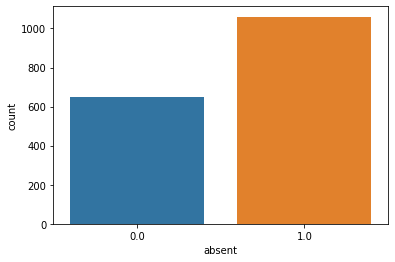

In [12]:
# Plot distribution of 'absent' column
ax = sns.countplot(abscodes.absent, label="Count")
A, P = abscodes.absent.value_counts()
print(f'Absent: {A}')
print(f'Present: {P}')

2    1060
3     253
4     177
6     129
1      92
Name: abs_type, dtype: int64

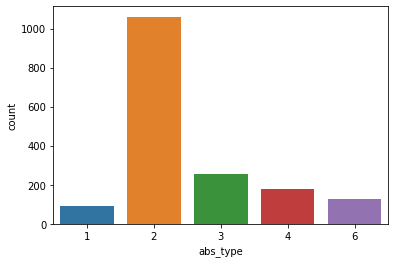

In [13]:
# Plot distribution of 'absent_type' column
ax2 = sns.countplot(abscodes.abs_type,label="Count")
abscodes.abs_type.value_counts()

Distribution of the abs type code is unbalanced. 
'abs_type'==2 indicates present ('absent' == 0).  
All of the types for 'absent' == 1 are divided among four different types. We might want to work on classifying 'abs_type' in the future; for now, let's focus on classifying 'absent' classes.

In [14]:
# Now that we've cleaned the dataframe as needed, reset the index
abscodes = abscodes.reset_index()
print('Processed data shape:', abscodes.shape)

Processed data shape: (1711, 15)


#    
#### Let's look at the raw absence descriptions.

In [15]:
# unique number of abs_desc1
print('Unique number of abs_desc1:', abscodes.abs_desc1.nunique(), '\n')
print('*-- Examples of abs_desc1 when absent == 1 --*')
print(abscodes.abs_desc1[abscodes.absent==1].sample(5, random_state = 93))
print('\n*-- Examples of abs_desc1 when absent == 0 --*')
print(abscodes.abs_desc1[abscodes.absent==0].sample(5, random_state = 93))

Unique number of abs_desc1: 470 

*-- Examples of abs_desc1 when absent == 1 --*
1068    OUT OF SCHOOL SUSPENSION
1585          Vacation-Unexcused
1485                    UNEX ABS
190                   AUTHORIZED
948      MEDICAL EXCUSED PARTIAL
Name: abs_desc1, dtype: object

*-- Examples of abs_desc1 when absent == 0 --*
514                             NaN
773                             ISS
1625                       UN TARDY
40              Suspension-InSchool
394     Early Departure - Unexcused
Name: abs_desc1, dtype: object


In [16]:
# unique number of abs_desc2
print('Unique number of abs_desc2:', abscodes.abs_desc2.nunique(), '\n')
print('----- Examples of abs_desc2 when absent == 1 -----')
print(abscodes.abs_desc2[abscodes.absent==1].sample(5, random_state = 93))
print('\n----- Examples of abs_desc2 when absent == 0 -----')
print(abscodes.abs_desc2[abscodes.absent==0].sample(5, random_state = 93))

Unique number of abs_desc2: 84 

----- Examples of abs_desc2 when absent == 1 -----
1068    NaN
1585    NaN
1485    NaN
190     NaN
948     NaN
Name: abs_desc2, dtype: object

----- Examples of abs_desc2 when absent == 0 -----
514         Early Dismissal
773                     NaN
1625                    NaN
40      Suspension-InSchool
394                     NaN
Name: abs_desc2, dtype: object


In [17]:
# unique number of abs_code2
print('Unique number of abs_code2:', abscodes.abs_code2.nunique(), '\n')
print('----- Examples of abs_code2 when absent == 1 -----')
print(abscodes.abs_code2[abscodes.absent==1].sample(5, random_state = 93))
print('\n----- Examples of abs_desc2 when absent == 0 -----')
print(abscodes.abs_code2[abscodes.absent==0].sample(5, random_state = 93))

Unique number of abs_code2: 234 

----- Examples of abs_code2 when absent == 1 -----
1068    OSS
1585      V
1485      U
190       A
948      MP
Name: abs_code2, dtype: object

----- Examples of abs_desc2 when absent == 0 -----
514     EDU
773       I
1625      X
40       SI
394     D U
Name: abs_code2, dtype: object


# 

## 2. Preprocessing texts

__We are going to use absence code and descriptions for classification. We will follow these steps:__     
    
__1) Concatenate abs_desc1 and abs_desc2 (for rows where abs_desc1 == abs_desc2,  just use abs_desc1)   
2) Processing concatenated description using these steps:   
$\;\;\;\;$ -Use lower case    
$\;\;\;\;$ -Remove punctuations/special characeters   
$\;\;\;\;$ -Lemmatize  
$\;\;\;\;$ -Remove stop words   
3) Concatenate abs_code2 to the processed descriptions.__ 

In [18]:
# Define special characters to remove from text
remove = string.punctuation
punct = r'[{}]'.format(remove)
# print(punct)

In [19]:
# In-school and out-of-school suspension distinction is important. So we won't remove these two stopwords.
stop = set(stopwords.words('english'))  - {'in', 'out'}  
# print(stop)

In [20]:
# Create an instance of lemmatizer
stemmer = WordNetLemmatizer()

In [21]:
# Make sure abs_descs are set to type string
abscodes.abs_desc1 = abscodes.abs_desc1.astype(str)
abscodes.abs_desc2 = abscodes.abs_desc2.astype(str)

In [22]:
# Clean abs_desc1
clean_abs_desc1_list = []


for i in range(abscodes.shape[0]):
    
    # Make it all lower case
    clean_abs_desc1 =  abscodes.abs_desc1[i].lower()
    
    # Remove punctations
    clean_abs_desc1 = re.sub(punct, " ",clean_abs_desc1)

    # Lemmatize words
    clean_abs_desc1 = [stemmer.lemmatize(word) for word in clean_abs_desc1.split()]
        
    # Remove stopwords
    clean_abs_desc1 = ' '.join([word for word in clean_abs_desc1 if word not in stop])
    
    # Append the clean abs description to the list
    clean_abs_desc1_list.append(clean_abs_desc1)

# Combine with original dataset    
abscodes['clean_abs_desc1'] = clean_abs_desc1_list

In [23]:
# Clean abs_desc2
clean_abs_desc2_list = []

for i in range(abscodes.shape[0]):
    
    clean_abs_desc2 =  abscodes.abs_desc2[i].lower()
    
    # Remove punctations
    clean_abs_desc2 = re.sub(punct, " ",clean_abs_desc2)
    
    # Lemmatize words
    clean_abs_desc2 = [stemmer.lemmatize(word) for word in clean_abs_desc2.split()]

    # Remove stopwords
    clean_abs_desc2 = ' '.join([word for word in clean_abs_desc2 if word not in stop])
    
    # Append the clean abs description to the list
    clean_abs_desc2_list.append(clean_abs_desc2)

# Combine with original dataset    
abscodes['clean_abs_desc2'] = clean_abs_desc2_list

In [24]:
# If abs_desc1 == abs_desc2, replace abs_desc2 to be an emtpry string before we concatenate them 
for i in range(abscodes.shape[0]):
    if abscodes.clean_abs_desc1[i] == abscodes.clean_abs_desc2[i]:
        abscodes.clean_abs_desc2[i] = ''

/Users/jil380/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
# Now, we want to concatenate abs_code2, clean_abs_desc1, and clean_abs_desc2. 
# Since abs_code2 are just codes, use it as is.
abscodes.abs_code2 = abscodes.abs_code2.astype(str)
abscodes['clean_abs'] = abscodes['abs_code2'].replace('nan', '') + ' ' + abscodes['clean_abs_desc1'].replace('nan', '') + ' ' + abscodes['clean_abs_desc2'].replace('nan', '')

In [26]:
abscodes.sample(5, random_state=92)

,index,pid,local_excused,category1,abs_code1,abs_desc1,category2,abs_code2,abs_desc2,abs_type,absent,excused,unexcused,suspended,dw_code,clean_abs_desc1,clean_abs_desc2,clean_abs
1123,1182,47795,Excused,AbsenceReason,ALLREASON,PARTIAL ABSENCE-EXCUSED,AbsenceType,PE,nan,2,1.0,1.0,0.0,0.0,21100.0,partial absence excused,nan,PE partial absence excused
103,162,47720,Unexcused,AbsenceReason,ALLREASON,Excused Late/Tardy,AbsenceType,7,nan,3,0.0,0.0,0.0,0.0,30000.0,excused late tardy,nan,7 excused late tardy
1445,1508,47795,Unexcused,AbsenceReason,ALLREASON,TARDY-UNEXCUSED,AbsenceType,TU,nan,3,0.0,0.0,0.0,0.0,30000.0,tardy unexcused,nan,TU tardy unexcused
693,752,48793,Family Emergency,AbsenceReason,ALLREASON,Family Emergency-1/2,AbsenceType,HFE,Family Emergency-1/2,2,1.0,1.0,0.0,0.0,21100.0,family emergency 1 2,,HFE family emergency 1 2
289,348,47720,Unexcused,AbsenceReason,ALLREASON,Medical,AbsenceType,B,nan,2,1.0,0.0,1.0,0.0,21010.0,medical,nan,B medical


#  
## 3. Create a bag-of-words model

#### 3.1 Split train and test data

In [27]:
# Separate our target variable from the text feature
x = abscodes['clean_abs']
y = abscodes['absent']

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 91)

In [29]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1197,) (514,) (1197,) (514,)


#### 3.2  Vectorize trainset using TF-IDF vectorizer

In [30]:
# Create an instance of the vectorizer
transformer = TfidfVectorizer()

# Fit the transfomer to x_train
x_tfidf = transformer.fit_transform(x_train).toarray()

# Transform the x_test using the TFIDF vectorizer 
x_test_tfidf = transformer.transform(x_test).toarray()

#  
## 4. Build Models

#### 4.1 Random Forest Classifier

In [31]:
# Create an instance of RF Classifier
rf = RandomForestClassifier(random_state = 91)

# Train on training set
rf.fit(x_tfidf, y_train)

# Predict the classifier
rf_y_pred = rf.predict(x_test_tfidf)
rf_y_pred_train = rf.predict(x_tfidf)

# Compare the training and test accuracy score
print("Training Accuracy Score:", round(accuracy_score(y_train,rf_y_pred_train)*100,2), "%")
print("Test Accuracy Score:", round(accuracy_score(y_test,rf_y_pred)*100,2), "%")

Training Accuracy Score: 98.16 %
Test Accuracy Score: 96.3 %


1.0    326
0.0    188
Name: absent, dtype: int64


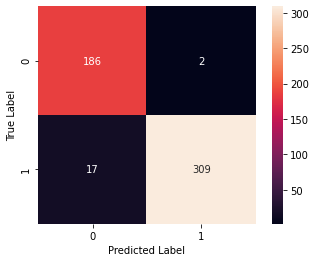

In [32]:
# Let's create confusion matrix 
cm = confusion_matrix(y_test, rf_y_pred)
sns.heatmap(cm, square=True, annot=True, fmt="d")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

print(y_test.value_counts())

99% (186/188)  of true_label==0 was predicted correctly. In contrast, only 95% (309/326) of true_label==1 was correct.

In [33]:
# Create test_df to see which clean_abs the model is predicting inaccurately
test_df = pd.DataFrame(
    {'clean_abs' : x_test,
     'true_label': y_test,
     'predicted' : rf_y_pred
    })

In [34]:
# Get rows where prediction was inaccurate.
test_df[test_df.true_label != test_df.predicted].sort_values(['true_label','clean_abs'])

,clean_abs,true_label,predicted
1173,PRU partial absence unexcused,0.0,1.0
1247,R school rel,0.0,1.0
212,A U,1.0,0.0
241,AE,1.0,0.0
297,B b115,1.0,0.0
298,B tardy ex,1.0,0.0
563,F fire,1.0,0.0
815,J job shadowing,1.0,0.0
987,N power,1.0,0.0
1023,NP power,1.0,0.0


I am surprised to find 'O susp' was predicted 'absent==0'. When coded as 'O' instead of 'OSS', the model doesn't know it is Out of school Suspension.

# 

#### 4.2 Logistic Regression

In [35]:
# Logistic regression model
logreg = LogisticRegression()

# Fit training data
logreg.fit(x_tfidf, y_train)

# Predict 
logreg_y_pred = logreg.predict(x_test_tfidf)
logreg_y_pred_train = rf.predict(x_tfidf)

print("Training Accuracy Score:", round(accuracy_score(y_train,logreg_y_pred_train)*100,2), "%")
print("Test Accuracy Score:", round(accuracy_score(y_test,logreg_y_pred)*100,2), "%")

Training Accuracy Score: 98.16 %
Test Accuracy Score: 94.55 %


Text(83.40000000000006, 0.5, 'True Label')

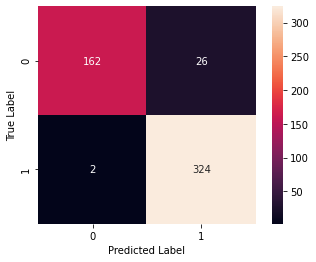

In [36]:
# Let's create confusion matrix 
cm = confusion_matrix(y_test, logreg_y_pred)
sns.heatmap(cm, square=True, annot=True, fmt="d")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Logistic regression yields the same training accuracy but lower test accuracy, compared to the random forest classfier.

#  
#### 4.3 Naive Bayes

In [39]:
nb = GaussianNB(); 
nb.fit(x_tfidf, y_train) 
  
# Predicting test set results 
nb_y_pred = nb.predict(x_test_tfidf) 
nb_y_pred_train = nb.predict(x_tfidf)

print("Training Accuracy Score:", round(accuracy_score(y_train,nb_y_pred_train)*100,2), "%")
print("Test Accuracy Score:", round(accuracy_score(y_test,nb_y_pred)*100,2), "%")

Training Accuracy Score: 81.04 %
Test Accuracy Score: 77.24 %


It assumes that the features are independent of each other. I believe the poor performance of naive bayes is due to the violation of this assumption.

#     
#### 4.4 LDA

In [40]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_tfidf,y_train)

lda_y_pred = lda.predict(x_test_tfidf) 
lda_y_pred_train = lda.predict(x_tfidf)

print("Training Accuracy Score:", round(accuracy_score(y_train,lda_y_pred_train)*100,2), "%")
print("Test Accuracy Score:", round(accuracy_score(y_test,lda_y_pred)*100,2), "%")

Training Accuracy Score: 97.83 %
Test Accuracy Score: 95.14 %


/Users/jil380/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


__Comments:__ 
1. I wonder if lemmatizing is hurting the model since the absence description is already succinct. 
   I tried it without lemmatization and it didn't improve the model at all.
2. I tried removing numbers from the abs_desc while preprocessing and it hurt performance a lot.
3. I also attempted using countvectorizer instead of the tf-idf vectorizer but it didn't improve performance.
4. To confirm that it was a good choice to not remove 'in' and 'out' when removing all the other stopwords, I also ran a model that removed them and the performance decreased.

# 

## 5. Hyper Parameter Tuning

We should tune hyper parameters in the model to improve the performance of random forest classifier, which had the highest performance.

In [41]:
n_estimator_range = np.arange(1, 700, 100)
train_score, val_score = validation_curve(
                                RandomForestClassifier(),
                                X = x_tfidf, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimator_range,
                                cv = 5)

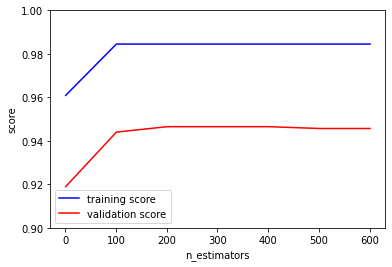

In [42]:
plt.plot(n_estimator_range, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(n_estimator_range, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0.9, 1)
plt.xlabel('n_estimators')
plt.ylabel('score');

In [43]:
# Tuning max_depth
max_depth_range = np.arange(1, 500, 5)
train_score, val_score = validation_curve(
                                RandomForestClassifier(),
                                X = x_tfidf, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_depth_range,
                                cv = 5)

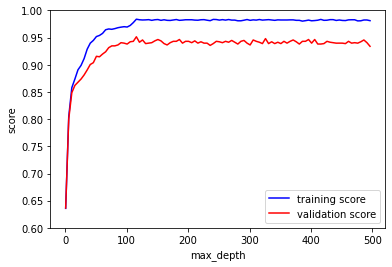

In [44]:
plt.plot(max_depth_range, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(max_depth_range, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0.6, 1)
plt.xlabel('max_depth')
plt.ylabel('score');

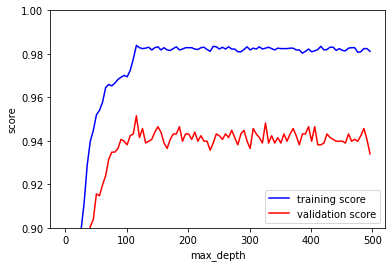

In [45]:
plt.plot(max_depth_range, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(max_depth_range, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0.9, 1)
plt.xlabel('max_depth')
plt.ylabel('score');

In [46]:
# Tuning min_sample_leaf
min_samples_leaf_range = np.arange(1, 10, 1)
train_score, val_score = validation_curve(
                                RandomForestClassifier(),
                                X = x_tfidf, y = y_train, 
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf_range,
                                cv = 5)

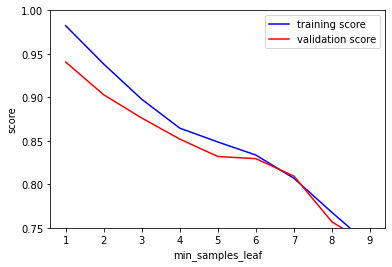

In [47]:
plt.plot(min_samples_leaf_range, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(min_samples_leaf_range, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0.75, 1)
plt.xlabel('min_samples_leaf')
plt.ylabel('score');

In [56]:
# Tuning min_sample_leaf
min_samples_split_range = np.arange(2, 10, 1)
train_score, val_score = validation_curve(
                                RandomForestClassifier(),
                                X = x_tfidf, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split_range,
                                cv = 5)

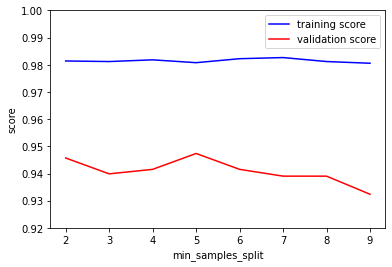

In [57]:
plt.plot(min_samples_split_range, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(min_samples_split_range, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0.92, 1)
plt.xlabel('min_samples_split')
plt.ylabel('score');

#### Let's use the new model with tuned hyper parameters

In [58]:
# Create an instance of RF Classifier
rf2= RandomForestClassifier(min_samples_split=5,
                            random_state = 91)

# Train on training set
rf2.fit(x_tfidf, y_train)

# Predict the classifier
rf2_y_pred = rf2.predict(x_test_tfidf)
rf2_y_pred_train = rf2.predict(x_tfidf)

# Compare the training and test accuracy score
print("Training Accuracy Score:", round(accuracy_score(y_train,rf2_y_pred_train)*100,2), "%")
print("Test Accuracy Score:", round(accuracy_score(y_test,rf2_y_pred)*100,2), "%")

Training Accuracy Score: 98.16 %
Test Accuracy Score: 96.69 %


The default values for the random forest classifier was good enough. Even after tuning the parameters, the test accuracy score only improved by 0.3%.

Text(83.40000000000006, 0.5, 'True Label')

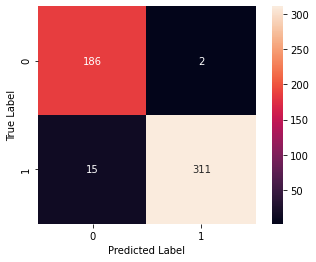

In [59]:
# Let's create confusion matrix 
cm = confusion_matrix(y_test, rf2_y_pred)
sns.heatmap(cm, square=True, annot=True, fmt="d")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [60]:
# Create test_df to see which clean_abs the model is predicting inaccurately
test_df = pd.DataFrame(
    {'clean_abs' : x_test,
     'true_label': y_test,
     'predicted' : rf2_y_pred
    })
test_df[test_df.true_label != test_df.predicted].sort_values(['true_label','clean_abs'])

,clean_abs,true_label,predicted
1173,PRU partial absence unexcused,0.0,1.0
1247,R school rel,0.0,1.0
212,A U,1.0,0.0
241,AE,1.0,0.0
297,B b115,1.0,0.0
298,B tardy ex,1.0,0.0
563,F fire,1.0,0.0
815,J job shadowing,1.0,0.0
987,N power,1.0,0.0
1023,NP power,1.0,0.0


# 
## Conclusion

__In this project, I used absencode code that are mostly one or two words and absence descriptions that are from a couple of words to a few sentences for binary classification of 'absent' variable. Creaing a bag-of-words model using TF-IDF vectorizer and applying random forest classifier yield about 96.7% of accuracy on testing set.__ 

__I've tried tuning some of the most important hyperparameters for the random forest classifier. All of the default values for the classifier already seem to work well so hyperparameter tuning didn't add too much value.__

__While the model's performance isn't too bad, we still see some rooms for improvement. For example, 'O suspension' is classified as present (absent == 0) even though Out of school suspension is actually considered as absent.__

__However, a high improvement of this model might not be easy because the absence description is very succinct and in some cases, some districts have conflicting absent values for the same absence codes. Hence, there might be some difficulty in achieving very high accuracy given our dataset.__
